### Imports, settings, globals

In [2]:
### Set CUDA device
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [3]:
from typing import Dict, List, Callable, Tuple, List
import numpy as np
import tqdm
import torch #
from torch.utils.data import DataLoader, default_collate
from torch import Tensor, nn #
import sys
from omegaconf import OmegaConf, open_dict
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from copy import deepcopy


sys.path.append('../')
from data_utils import get_train_loader, get_eval_data
from model.unet import get_unet

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.


In [68]:
dsc = Dice(
    num_classes=4,
    # zero_division=0,
    # mdmc_average='samplewise',
    average='samples',
)

In [70]:
# pred = torch.randint(0, 4, (20,  10))
# target = torch.randint(0, 4, (20,  10))

# dsc(pred, target)
pred = torch.tensor([1,0,0,0])
target = torch.tensor([0,0,0,0])

dsc(pred, target)

tensor(0.7500)

In [65]:
pred = torch.tensor([0,0,0,0])
target = torch.tensor([0,0,0,0])

dsc(pred, target)

tensor(1.)

In [40]:
# pred = torch.randint(0, 2, (20,  10))
# target = torch.randint(0, 2, (20,  10))

dsc(pred, target)

tensor(0.4550)

In [42]:
### Load basic config
cfg = OmegaConf.load('../configs/basic_config_venusberg.yaml')
OmegaConf.update(cfg, 'run.iteration', 0)

In [43]:
with open_dict(cfg):
    OmegaConf.update(
        cfg, 
        'dae',
        OmegaConf.load('../configs/dae/CompressionDAE_config.yaml')
    )

    cfg.dae.placement = 'bottleneck'
    cfg.dae.name = 'CompressionDAE-bottleneck-3-4'
    cfg.dae.postfix = '_residual'
    cfg.dae.arch.depth = 3
    cfg.dae.arch.block = 4
    cfg.dae.arch.residual = True

In [18]:
OmegaConf.update(
    cfg, 
    'dae',
    OmegaConf.load('../configs/dae/ResDAE_config.yaml')
)

cfg.dae.placement = 'bottleneck'
cfg.dae.name = 'ResDAE-bottleneck-32'
cfg.dae.postfix = '_instance-reconstruction'
cfg.dae.arch.depth = 3
# cfg.dae.arch.block = 2
cfg.dae.arch.residual = False
# cfg.dae.arch.spatial = [256, 128, 64, 32]

### UNet Models

In [44]:
### Set dataset, either brain or heart
DATA_KEY = 'heart'
OmegaConf.update(cfg, 'run.data_key', DATA_KEY)


### get model
# available models:
#     - default-8
#     - default-16
#     - monai-8-4-4
#     - monai-16-4-4
#     - monai-32-4-4
#     - monai-64-4-4
#     - swinunetr

#unet_name = 'monai-64-4-4'
unet_name = 'default-8'
args = unet_name.split('-')
cfg.unet[DATA_KEY].pre = unet_name
cfg.unet[DATA_KEY].arch = args[0]
cfg.unet[DATA_KEY].n_filters_init = None if unet_name == 'swinunetr' else int(args[1])
if args[0] == 'monai':
    cfg.unet[DATA_KEY].depth = int(args[2])
    cfg.unet[DATA_KEY].num_res_units = int(args[3])

unet, state_dict = get_unet(
    cfg,
    update_cfg_with_swivels=True,
    return_state_dict=True)
unet.load_state_dict(state_dict)
_ = unet.cuda()


### Data

In [6]:
# Set debug mode for only a small fraction of the datasets. Speeds up this cell by alot
cfg.debug = False

# update config with default values
with open_dict(cfg):
    OmegaConf.update(
        cfg, 
        'eval',
        OmegaConf.load('../configs/eval/unet_config.yaml')
    )

# Wether and how you want to subset in case of Brain data. WARNING:
# After subsetting the eval below will not work with surface
# Dice anymore, because volumes are fragmented. 
APPLY_SUBSETTING = True
OmegaConf.update(cfg, 'eval.data.subset.apply', APPLY_SUBSETTING)
subset_params = {
    'n_cases': 256,  # selects at most so many cases
    'fraction': 0.1, # selects from the 10% worst cases w.r.t to a model
}
OmegaConf.update(
    cfg, 
    'eval.data.subset.params', 
    OmegaConf.create(subset_params)
)

if cfg.eval.data.subset.apply:
    subset_dict = OmegaConf.to_container(
        cfg.eval.data.subset.params, 
        resolve=True, 
        throw_on_missing=True
    )
    subset_dict['unet'] = unet
else:
    subset_dict = None

### select the datasets within the domain
# get training data
cfg.eval.data.training = False
# get validation data
cfg.eval.data.validation = True
# get testing data
# Options for Brain are any subset of [1, 2, 3, 4, 5] or 'all' 
# Options for Heart are any subset of ['A', 'B', 'C', 'D'] or 'all'
cfg.eval.data.testing = 'all'


raw_data = get_eval_data(
    train_set=cfg.eval.data.training,
    val_set=cfg.eval.data.validation,
    test_sets=cfg.eval.data.testing,    
    cfg=cfg,
    subset_dict=subset_dict
)


print(f'\nAvailable datasets are: {list(raw_data.keys())}')

loading dataset
loading all case properties


loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties

Available datasets are: ['val', 'A', 'B', 'C', 'D']


In [7]:
# get data
train_loader, val_loader = get_train_loader(
    training='unet', 
    cfg=cfg
)

loading dataset
loading all case properties


loading dataset
loading all case properties


### Slice Wise uncertainty Measures

Accuracy-Rejection (or [E]-AURC) get it from here: https://github.com/IML-DKFZ/values/blob/main/evaluation/metrics/aurc.py

AUROC 


In [1]:
from typing import List, Tuple

import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader, default_collate
from torchmetrics import (
    SpearmanCorrCoef, 
    AUROC,
    ROC,
    Dice
)
from torchmetrics.utilities.compute import _auc_compute_without_check
import numpy as np


from model.mahalanobis_adatper import BatchNormMahalanobisDetector, PoolingMahalanobisDetector
from model.wrapper import BatchNormMahalanobisWrapper, PoolingMahalanobisWrapper


class AUROC(nn.Module):
    def __init__(
        self, 
        ret_curves: bool = True
    ):
        super().__init__()
        # args
        self.ret_curves = ret_curves
        # metrics
        self.roc_values = ROC(task='binary')

    @torch.no_grad()
    def auroc(
        self,
        confids: Tensor,
        target: Tensor
    ):
        
        confids = (confids - confids.min()) / (confids.max() - confids.min())
        fpr, tpr, _ = self.roc_values(
            confids,
            target
        )

        ret = _auc_compute_without_check(
            x=fpr,
            y=tpr,
            direction=1.0
        )

        if self.ret_curves:
            return ret, fpr, tpr
        else:
            return ret

    @torch.no_grad()
    def forward(
        self,
        confids: Tensor,
        target: Tensor
    ):
        return self.auroc(confids=confids, target=target)



class EAURC(nn.Module):
    def __init__(
        self,
        ret_curves: bool = True
    ):
        super().__init__()
        # args
        self.ret_curves = ret_curves
        
    @torch.no_grad()
    def _rc_curve_stats(
        self,
        confids: np.array, 
        risks: np.array
    ) -> Tuple[List[float], List[float], List[float]]:
        coverages = []
        selective_risks = []
        assert (
            len(risks.shape) == 1 and len(confids.shape) == 1 and len(risks) == len(confids)
        )

        n_samples = len(risks)
        idx_sorted = np.argsort(confids)

        coverage = n_samples
        error_sum = sum(risks[idx_sorted])

        coverages.append(coverage / n_samples)
        selective_risks.append(error_sum / n_samples)

        weights = []

        tmp_weight = 0
        for i in range(0, len(idx_sorted) - 1):
            coverage = coverage - 1
            error_sum = error_sum - risks[idx_sorted[i]]
            tmp_weight += 1
            if i == 0 or confids[idx_sorted[i]] != confids[idx_sorted[i - 1]]:
                coverages.append(coverage / n_samples)
                selective_risks.append(error_sum / (n_samples - 1 - i))
                weights.append(tmp_weight / n_samples)
                tmp_weight = 0

        # add a well-defined final point to the RC-curve.
        if tmp_weight > 0:
            coverages.append(0)
            selective_risks.append(selective_risks[-1])
            weights.append(tmp_weight / n_samples)

        return coverages, selective_risks, weights

    @torch.no_grad()
    def _aurc(
        self,
        confids: np.array, 
        risks: np.array
    ):
        _, risks, weights = self._rc_curve_stats(confids=confids, risks=risks)

        ret = sum(
            [(risks[i] + risks[i + 1]) * 0.5 * weights[i] for i in range(len(weights))]
        )

        if self.ret_curves:
            return ret, risks, weights
        else:
            return ret

    @torch.no_grad()
    def eaurc(
        self,
        score: Tensor, 
        risks: Tensor
    ):
        """Compute normalized AURC, i.e. subtract AURC of optimal CSF (given fixed risks)."""
        n = len(risks)
        score = score.numpy()
        score = (score - score.min()) / (score.max() - score.min())
        confids = 1 - score
        risks = risks.numpy()
        # optimal confidence sorts risk. Asencding here because we start from coverage 1/n
        selective_risks = np.sort(risks).cumsum() / np.arange(1, n + 1)
        aurc_opt = selective_risks.sum() / n
        ret, risks, weights = self._aurc(confids=confids, risks=risks)
        if self.ret_curves:
            risks   = torch.flip(torch.tensor(risks)[1:], [0])
            weights = torch.cumsum(torch.flip(torch.tensor(weights), [0]), 0)
            return ret - aurc_opt, ret, risks, weights, selective_risks
        else:
            return ret - aurc_opt, ret

    @torch.no_grad()
    def forward(
        self,
        score: Tensor,
        risks: Tensor
    ):
        return self.eaurc(score=score, risks=risks)

ModuleNotFoundError: No module named 'model'

In [9]:
def get_auroc_mahalanobis(
    wrapper: nn.Module,
    iid_data: Dataset,
    ood_data: Dataset,
    device: str = 'cuda:0',
):
    auroc = AUROC()
    
    batch_size = 32
    iid_loader = DataLoader(iid_data, batch_size=batch_size, shuffle=False)
    ood_loader = DataLoader(ood_data, batch_size=batch_size, shuffle=False)

    score_iid = []
    for batch in iid_loader:
        input_ = batch['input'].to(device)
        _ = wrapper(input_)
        score_iid.append({
            adapter.swivel: adapter.batch_distances.cpu().view(-1)
            for adapter in wrapper.adapters
        })
    target_iid = torch.zeros(len(iid_data))


    score_ood = []
    for batch in ood_loader:
        input_ = batch['input'].to(device)
        _ = wrapper(input_)
        score_ood.append({
            adapter.swivel: adapter.batch_distances.cpu().view(-1)
            for adapter in wrapper.adapters
        })
    target_ood = torch.ones(len(ood_data))
    
    score = {
        swivel: torch.cat([conf[swivel] for conf in score_iid + score_ood])
        for swivel in score_iid[0].keys()
    }
    
    target = torch.cat([target_iid, target_ood]).long()


    ret = {
        swivel: auroc(confids=score[swivel], target=target)
        for swivel in score.keys()
    }

    return ret


def get_eaurc_mahalanobis(
    wrapper: nn.Module,
    data: Dataset,
    net_out: str,
    device: str = 'cuda:0',
):
    eaurc = EAURC()
    dice = Dice(
        num_classes=2 if net_out == 'brain' else 4,
        average='micro', #'macro' if net_out == 'brain' else 'micro',
        mdmc_average= 'samplewise', #None if net_out == 'brain' else
        # multiclass=False if net_out == 'brain' else True,
        # ignore_index=0 if net_out == 'heart' else None,
        zero_division=1
    ).to(device)
    batch_size = 32

    loader = DataLoader(data, batch_size=batch_size, shuffle=False)
    
    score, risk = [], []
    for batch in loader:
        # grab data
        input_ = batch['input'].to(device)
        target = batch['target'].to(device).long()
        target[target == -1] = 0
        # inference
        output = wrapper(input_)
        if net_out == 'brain':
            segmap = (torch.sigmoid(output) > 0.5) * 1
        elif net_out == 'heart':
            segmap = torch.argmax(output, dim=1, keepdims=True)
        # collect risk and score
        # print(segmap.device, target.device)
        risk.append(
            torch.tensor([1 - dice(s, t) for s,t in zip(segmap, target)]).cpu()
        )
        score.append({
            adapter.swivel: adapter.batch_distances.cpu().view(-1)
            for adapter in wrapper.adapters
        })
    # aggregate results
    risk = torch.cat(risk)
    score = {
        swivel: torch.cat([conf[swivel] for conf in score])
        for swivel in score[0].keys()
    }
    # compute eaurc
    ret = {
        swivel: eaurc(score=score[swivel], risks=risk)
        for swivel in score.keys()
    }

    return ret

### Integrate DAE

In [11]:
with open_dict(cfg):
    OmegaConf.update(
        cfg, 
        'dae',
        OmegaConf.load('../configs/dae/CompressionDAE_config.yaml')
    )

    cfg.dae.placement = 'bottleneck'
    cfg.dae.name = 'Compression-bottleneck-32'
    cfg.dae.postfix = '_instance-reconstruction'
    cfg.dae.arch.depth = 3
    cfg.dae.arch.block = 2
    cfg.dae.arch.residual = False
    # cfg.dae.arch.spatial = [256, 128, 64, 32]

ConfigTypeError: Cannot merge DictConfig with ListConfig
    full_key: dae
    object_type=dict

In [45]:
from utils import load_state_dict_for_modulelists
from model.dae import get_daes


# get denoising models
unet, state_dict = get_unet(
    cfg=cfg, 
    update_cfg_with_swivels=True,
    return_state_dict=True
)
unet.load_state_dict(state_dict)


model, state_dict = get_daes(
    unet=unet,
    cfg=cfg, 
    return_state_dict=True
)

if cfg.dae.placement == 'all':
    model = load_state_dict_for_modulelists(model, state_dict)
elif cfg.dae.placement == 'bottleneck':
    model.load_state_dict(state_dict)

Disabling layer shortcut0, index 0 in identity_swivels.
Disabling layer shortcut1, index 1 in identity_swivels.
Disabling layer shortcut2, index 2 in identity_swivels.


In [12]:
from typing import Union
from utils import UMapGenerator


def get_auroc_output(
    model: nn.Module,
    iid_data: Dataset,
    ood_data: Dataset,
    net_out: str, 
    dae: bool,
    umap: str,
    device: str = 'cuda:0',
):
    if dae == True:
        model.remove_all_hooks()        
        model.hook_inference_transformations(model.transformations, n_samples=1)
        # Put model in evaluation state
        model.to(device)
        model.eval()
        model.freeze_seg_model()

    auroc = AUROC()
    umap_generator = UMapGenerator(
        method=umap,
        net_out=net_out,
    ).to(device)
    
    batch_size = 32
    iid_loader = DataLoader(iid_data, batch_size=batch_size, shuffle=False)
    ood_loader = DataLoader(ood_data, batch_size=batch_size, shuffle=False)

    score_iid = []
    for batch in iid_loader:
        input_ = batch['input'].to(device)
        output = model(input_)
        scores = umap_generator(output, batch_size=input_.shape[0]).cpu()
        score_iid.append(scores.mean(dim=(1,2,3)))
    target_iid = torch.zeros(len(iid_data))


    score_ood = []
    for batch in ood_loader:
        input_ = batch['input'].to(device)
        output = model(input_)
        scores = umap_generator(output, batch_size=input_.shape[0]).cpu()
        score_ood.append(scores.mean(dim=(1,2,3)))
    target_ood = torch.ones(len(ood_data))
    score = torch.cat(score_iid + score_ood)
    target = torch.cat([target_iid, target_ood]).long()

    return auroc(confids=score, target=target)


def get_eaurc_output(
    model: nn.Module,
    data: Dataset,
    net_out: str, 
    dae: bool,
    umap: str,
    device: str = 'cuda:0',
):
    
    if dae == True:
        model.remove_all_hooks()        
        model.hook_inference_transformations(model.transformations, n_samples=1)
        # Put model in evaluation state
        model.to(device)
        model.eval()
        model.freeze_seg_model()

    umap_generator = UMapGenerator(
        method=umap,
        net_out=net_out,
    ).to(device)    
    eaurc = EAURC()
    dice = Dice(
        num_classes=2 if net_out == 'brain' else 4,
        average='micro', #'macro' if net_out == 'brain' else 'micro', #'macro' if net_out == 'brain' else 
        mdmc_average= 'samplewise', #None if net_out == 'brain' else
        # multiclass=False if net_out == 'brain' else True,
        # ignore_index=0 if net_out == 'heart' else None,
        zero_division=1
    ).to(device)

    batch_size = 32

    loader = DataLoader(data, batch_size=batch_size, shuffle=False)
    
    score, risk = [], []
    for batch in loader:
        # grab data
        input_ = batch['input'].to(device)
        target = batch['target'].to(device).long()
        target[target == -1] = 0
        # inference
        output = model(input_)
        if net_out == 'brain':
            segmap = (torch.sigmoid(output[:batch_size]) > 0.5) * 1
        elif net_out == 'heart':
            segmap = torch.argmax(output[:batch_size], dim=1, keepdims=True)
        # collect risk and score
        scores = umap_generator(output, batch_size=input_.shape[0]).cpu()
        risk.append(
            torch.tensor([1 - dice(s, t) for s,t in zip(segmap, target)]).cpu()
        )
        score.append(scores.mean(dim=(1,2,3)))
    # aggregate results
    risk = torch.cat(risk)
    score = torch.cat(score)

    
    # compute eaurc and return
    return eaurc(score=score, risks=risk)

### AUROC MAHALANOBIS TEST

In [14]:
# Wrappers

device = 'cuda:0'
unet.to(device)

batchnorm_detector = BatchNormMahalanobisDetector(
    swivel='up3.0.conv_path.0.bn',
    device=device,
)
batchnorm_detector.train()
batchnorm_wrapper = BatchNormMahalanobisWrapper(
    model=unet,
    adapters=nn.ModuleList([batchnorm_detector])
)
batchnorm_wrapper.hook_adapters()
batchnorm_wrapper.eval()
print()


pooling_detector = PoolingMahalanobisDetector(
    swivel='up3.0.conv_path.0.bn',
    device=device,
    ledoitWolf=False
)
pooling_detector.train()
pooling_wrapper = PoolingMahalanobisWrapper(
    model=unet,
    adapters=nn.ModuleList([pooling_detector])
)
pooling_wrapper.hook_adapters()
for _ in tqdm.tqdm(range(250)):
    batch = next(train_loader)
    x = batch['data'].to(device)
    _ = pooling_wrapper(x)
pooling_detector.fit()
_ = pooling_detector.eval()


100%|██████████| 250/250 [00:53<00:00,  4.69it/s]


In [30]:
results = {
    'pooling': {
        'auroc': {},
        'eaurc': {}
    },
    'batchnorm': {
        'auroc': {},
        'eaurc': {}
    },
    'dae': {
        'auroc': {},
        'eaurc': {}
    }
}
for domain in raw_data:
    if domain == 'train':
        continue
    # if 'val' not in domain:

    #     pooling_auroc = get_auroc_mahalanobis(
    #         wrapper=pooling_wrapper,
    #         iid_data=raw_data['val'] if DATA_KEY == 'heart' else raw_data['val_subset'],
    #         ood_data=raw_data[domain],
    #         device=device
    #     )
    #     results['pooling']['auroc'][domain] = pooling_auroc['up3.0.conv_path.0.bn']

    #     batchnorm_auroc = get_auroc_mahalanobis(
    #         wrapper=batchnorm_wrapper,
    #         iid_data=raw_data['val'] if DATA_KEY == 'heart' else raw_data['val_subset'],
    #         ood_data=raw_data[domain],
    #         device=device
    #     )
    #     results['batchnorm']['auroc'][domain] = batchnorm_auroc['up3.0.conv_path.0.bn']

    #     dae_auroc = get_auroc_output(
    #         model=model,
    #         iid_data=raw_data['val'] if DATA_KEY == 'heart' else raw_data['val_subset'],
    #         ood_data=raw_data[domain],
    #         net_out=DATA_KEY,
    #         dae=True,
    #         umap='cross_entropy',
    #         device=device,
    #     )
    #     results['dae']['auroc'][domain] = dae_auroc

    eaurc_pooling = get_eaurc_mahalanobis(
        wrapper=pooling_wrapper,
        data=raw_data[domain],
        net_out=DATA_KEY,
        device=device
    )
    results['pooling']['eaurc'][domain] = eaurc_pooling['up3.0.conv_path.0.bn']

    eaurc_batchnorm = get_eaurc_mahalanobis(
        wrapper=batchnorm_wrapper,
        data=raw_data[domain],
        net_out=DATA_KEY,
        device=device
    )
    results['batchnorm']['eaurc'][domain] = eaurc_batchnorm['up3.0.conv_path.0.bn']

    eaurc_dae = get_eaurc_output(
        model=model,
        data=raw_data[domain],
        net_out=DATA_KEY,
        dae=True,
        umap='cross_entropy',
        device=device,
    )
    results['dae']['eaurc'][domain] = eaurc_dae

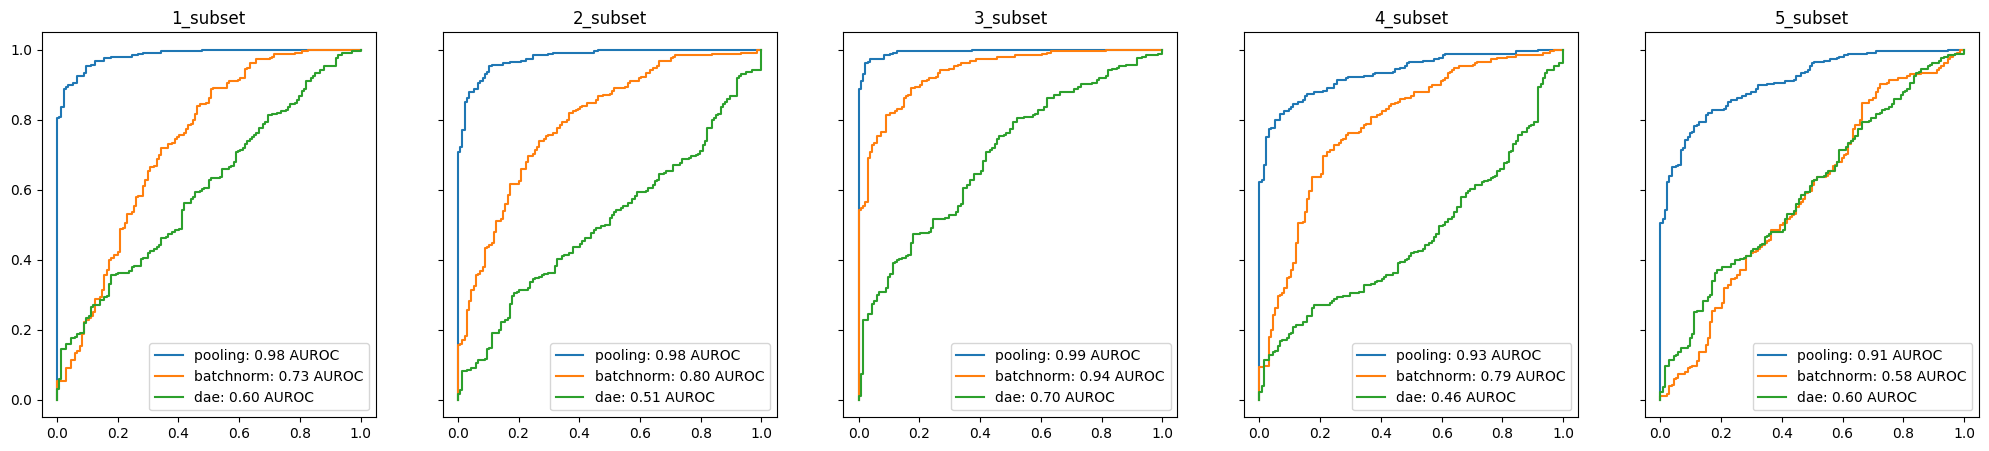

In [106]:
task = 'auroc'
methods = ['pooling', 'batchnorm', 'dae']
fig, axes = plt.subplots(1, len(raw_data)-1, figsize=((len(raw_data)-1)* 5, 5),sharey=True)

plt_ctr = 0
for i, domain in enumerate(raw_data.keys()):
    if domain in ['train', 'train_subset', 'val', 'val_subset']:
        continue
    for method in methods:


        auroc, fpr, tpr = results[method][task][domain]
        axes[plt_ctr].plot(fpr, tpr, label=f'{method}: {auroc:.2f} AUROC')
    axes[plt_ctr].legend()
    axes[plt_ctr].title.set_text(f'{domain}')
    plt_ctr += 1

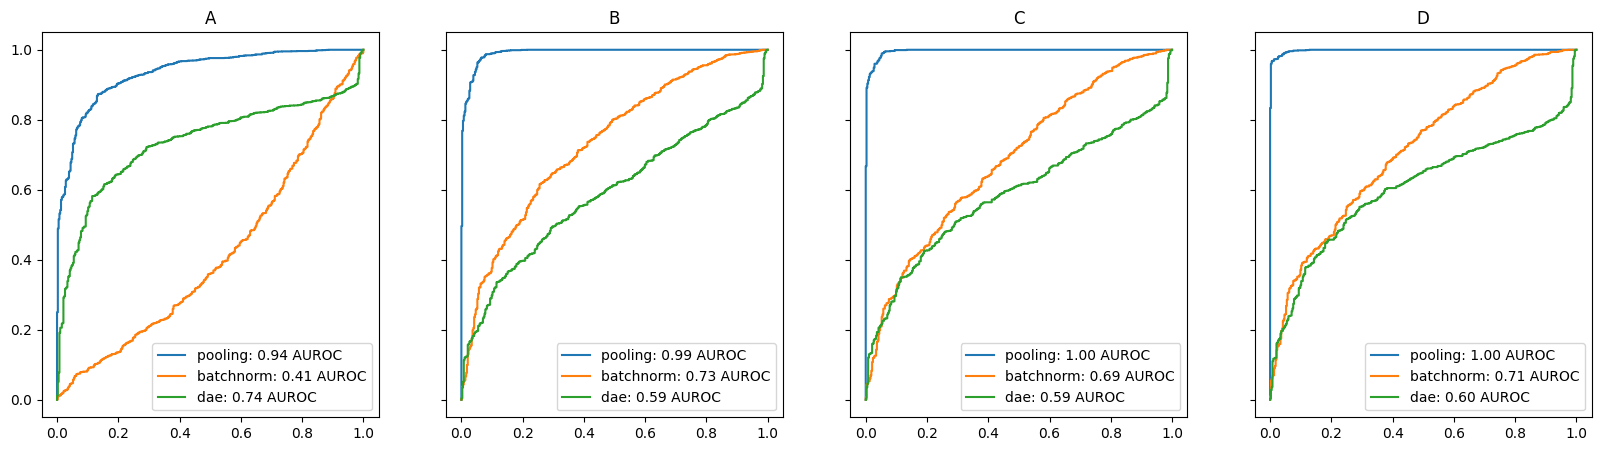

In [94]:
task = 'auroc'
methods = ['pooling', 'batchnorm', 'dae']
fig, axes = plt.subplots(1, len(raw_data)-1, figsize=((len(raw_data)-1)* 5, 5),sharey=True)

plt_ctr = 0
for i, domain in enumerate(raw_data.keys()):
    if domain in ['train', 'val']:
        continue
    for method in methods:


        auroc, fpr, tpr = results[method][task][domain]
        axes[plt_ctr].plot(fpr, tpr, label=f'{method}: {auroc:.2f} AUROC')
    axes[plt_ctr].legend()
    axes[plt_ctr].title.set_text(f'{domain}')
    plt_ctr += 1

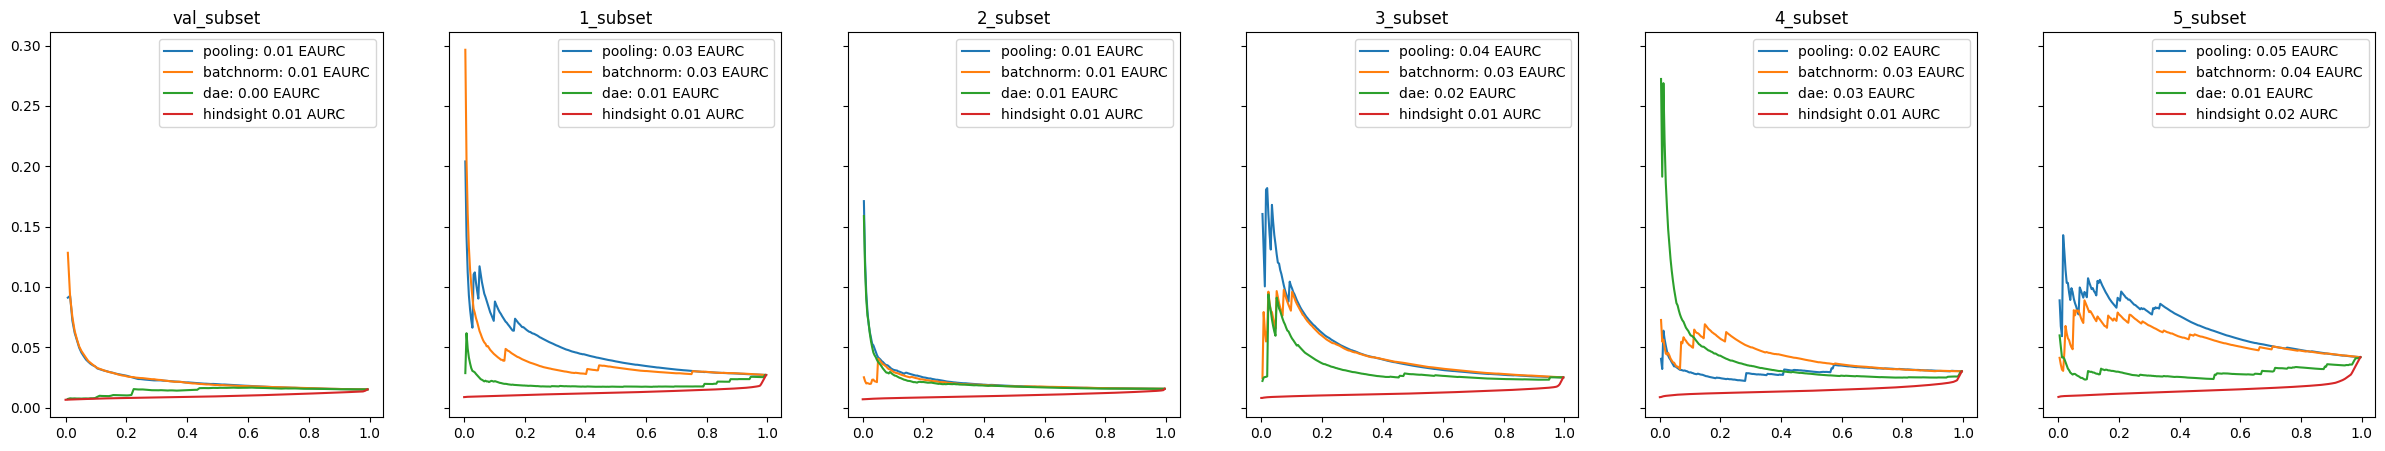

In [111]:
task = 'eaurc'
methods = ['pooling', 'batchnorm', 'dae']

fig, axes = plt.subplots(1, len(raw_data), figsize=((len(raw_data))* 5, 5), sharey=True)

plt_ctr = 0
for i, domain in enumerate(raw_data.keys()):
    if 'train' in domain:
        continue
    for method in methods:

        res, aurc, risk, weight, best_risks = results[method][task][domain]
        axes[plt_ctr].plot(weight, risk, label=f'{method}: {res:.2f} EAURC')
    
    axes[plt_ctr].plot(
        np.arange(0, len(best_risks)) / len(best_risks), 
        best_risks, 
        label=f'hindsight {best_risks[1:].sum() / len(best_risks[1:]):.2f} AURC'
    )

    axes[plt_ctr].legend()
    axes[plt_ctr].title.set_text(f'{domain}')
    plt_ctr += 1

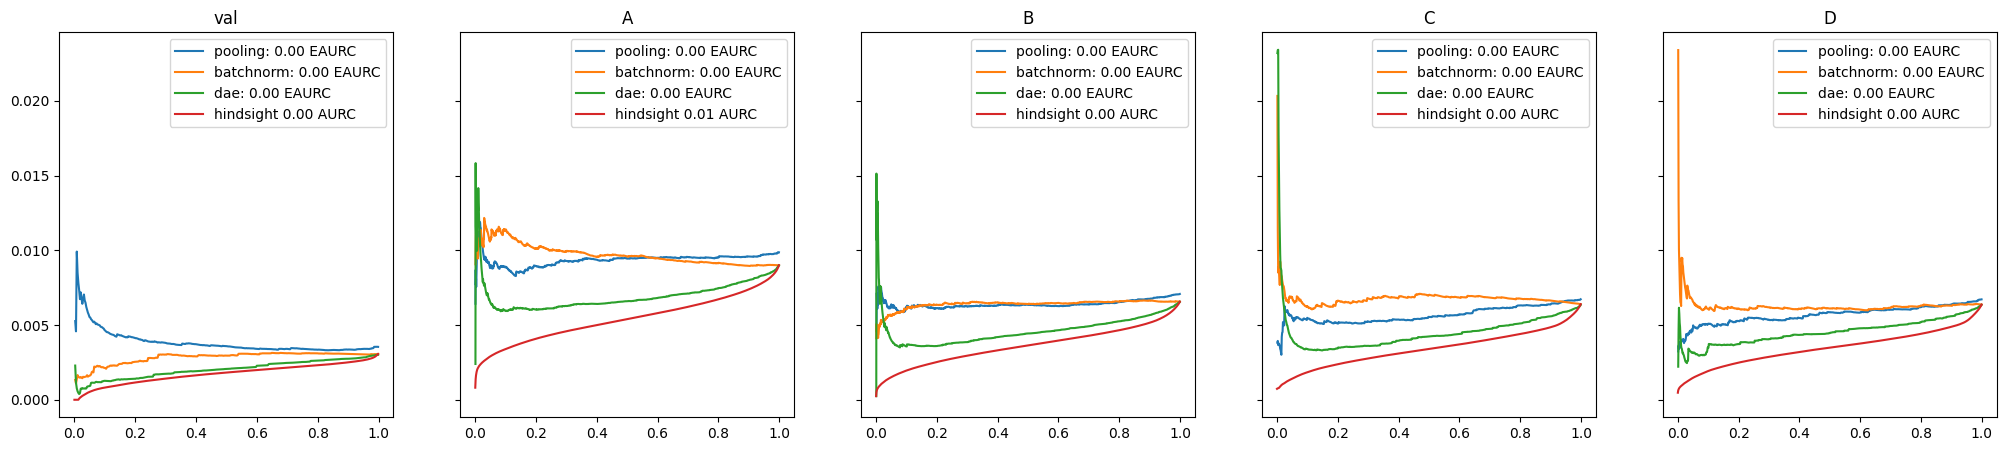

In [31]:
task = 'eaurc'
methods = ['pooling', 'batchnorm', 'dae']

fig, axes = plt.subplots(1, len(raw_data), figsize=((len(raw_data))* 5, 5), sharey=True)

plt_ctr = 0
for i, domain in enumerate(raw_data.keys()):
    if 'train' in domain:
        continue
    for method in methods:

        res, aurc, risk, weight, best_risks = results[method][task][domain]
        axes[plt_ctr].plot(weight, risk, label=f'{method}: {res:.2f} EAURC')

    axes[plt_ctr].plot(
        np.arange(0, len(best_risks)) / len(best_risks), 
        best_risks, 
        label=f'hindsight {best_risks[1:].sum() / len(best_risks[1:]):.2f} AURC'
    )

    axes[plt_ctr].legend()
    axes[plt_ctr].title.set_text(f'{domain}')
    plt_ctr += 1

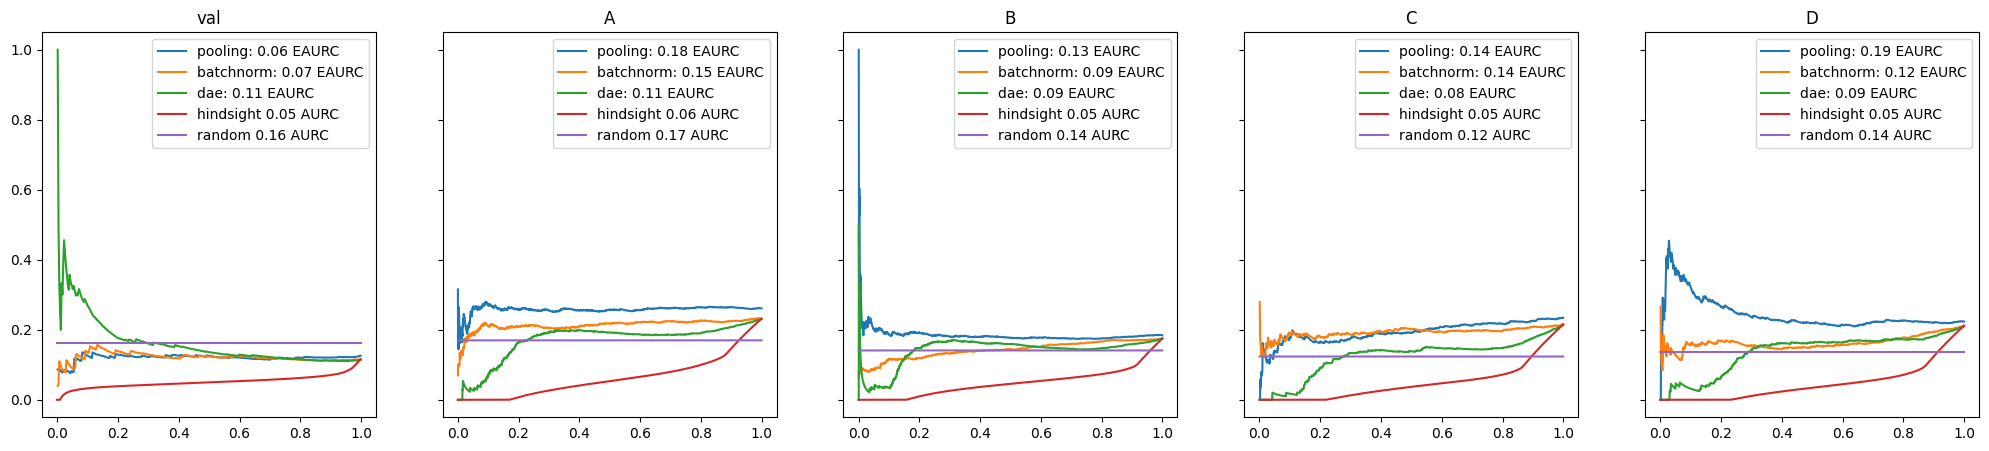

In [109]:
task = 'eaurc'
methods = ['pooling', 'batchnorm', 'dae']

fig, axes = plt.subplots(1, len(raw_data), figsize=((len(raw_data))* 5, 5), sharey=True)

plt_ctr = 0
for i, domain in enumerate(raw_data.keys()):
    if 'train' in domain:
        continue
    for method in methods:

        res, aurc, risk, weight, best_risks = results[method][task][domain]
        axes[plt_ctr].plot(weight, risk, label=f'{method}: {res:.2f} EAURC')
    
    axes[plt_ctr].plot(
        np.arange(0, len(best_risks)) / len(best_risks), 
        best_risks, 
        label=f'hindsight {best_risks[1:].sum() / len(best_risks[1:]):.2f} AURC'
    )

    axes[plt_ctr].plot(
        np.arange(0, len(risk)) / len(risk), 
        risk.mean().repeat(len(risk)),
        label=f'random {risk.mean():.2f} AURC'
    )
    axes[plt_ctr].legend()
    axes[plt_ctr].title.set_text(f'{domain}')
    plt_ctr += 1

In [13]:
def get_risk_score(
    model: nn.Module,
    data: Dataset,
    net_out: str, 
    dae: bool,
    umap: str,
    device: str = 'cuda:0',
):
    
    if dae == True:
        model.remove_all_hooks()        
        model.hook_inference_transformations(model.transformations, n_samples=1)
        # Put model in evaluation state
        model.to(device)
        model.eval()
        model.freeze_seg_model()

    umap_generator = UMapGenerator(
        method=umap,
        net_out=net_out,
    ).to(device)    
    eaurc = EAURC()
    dice = Dice(
        num_classes=2 if net_out == 'brain' else 4,
        average='micro', #'macro' if net_out == 'brain' else 'micro', #'macro' if net_out == 'brain' else 
        mdmc_average= 'samplewise', #None if net_out == 'brain' else
        # multiclass=False if net_out == 'brain' else True,
        # ignore_index=0 if net_out == 'heart' else None,
        zero_division=1
    ).to(device)

    batch_size = 32

    loader = DataLoader(data, batch_size=batch_size, shuffle=False)
    
    score, risk = [], []
    for batch in loader:
        # grab data
        input_ = batch['input'].to(device)
        target = batch['target'].to(device).long()
        target[target == -1] = 0
        # inference
        output = model(input_)
        if net_out == 'brain':
            segmap = (torch.sigmoid(output[:batch_size]) > 0.5) * 1
        elif net_out == 'heart':
            segmap = torch.argmax(output[:batch_size], dim=1, keepdims=True)
        # collect risk and score
        scores = umap_generator(output, batch_size=input_.shape[0]).cpu()
        risk.append(
            torch.tensor([1 - dice(s, t) for s,t in zip(segmap, target)]).cpu()
        )
        score.append(scores.mean(dim=(1,2,3)))
    # aggregate results
    risk = torch.cat(risk)
    score = torch.cat(score)

    values, indices = torch.sort(risk)

    # compute eaurc and return
    return risk, score

In [15]:
device = 'cuda:0'
risk, score = get_risk_score(
    model=model,
    data=raw_data['C'],
    net_out=DATA_KEY,
    dae=True,
    umap='cross_entropy',
    device=device,
)

In [38]:
n = 10
values, indices = torch.sort(score)
subset = raw_data['B'][indices[-n:]]

In [39]:
umap_generator = UMapGenerator(
    method='cross_entropy',
    net_out='heart',
)
# model.cpu() 

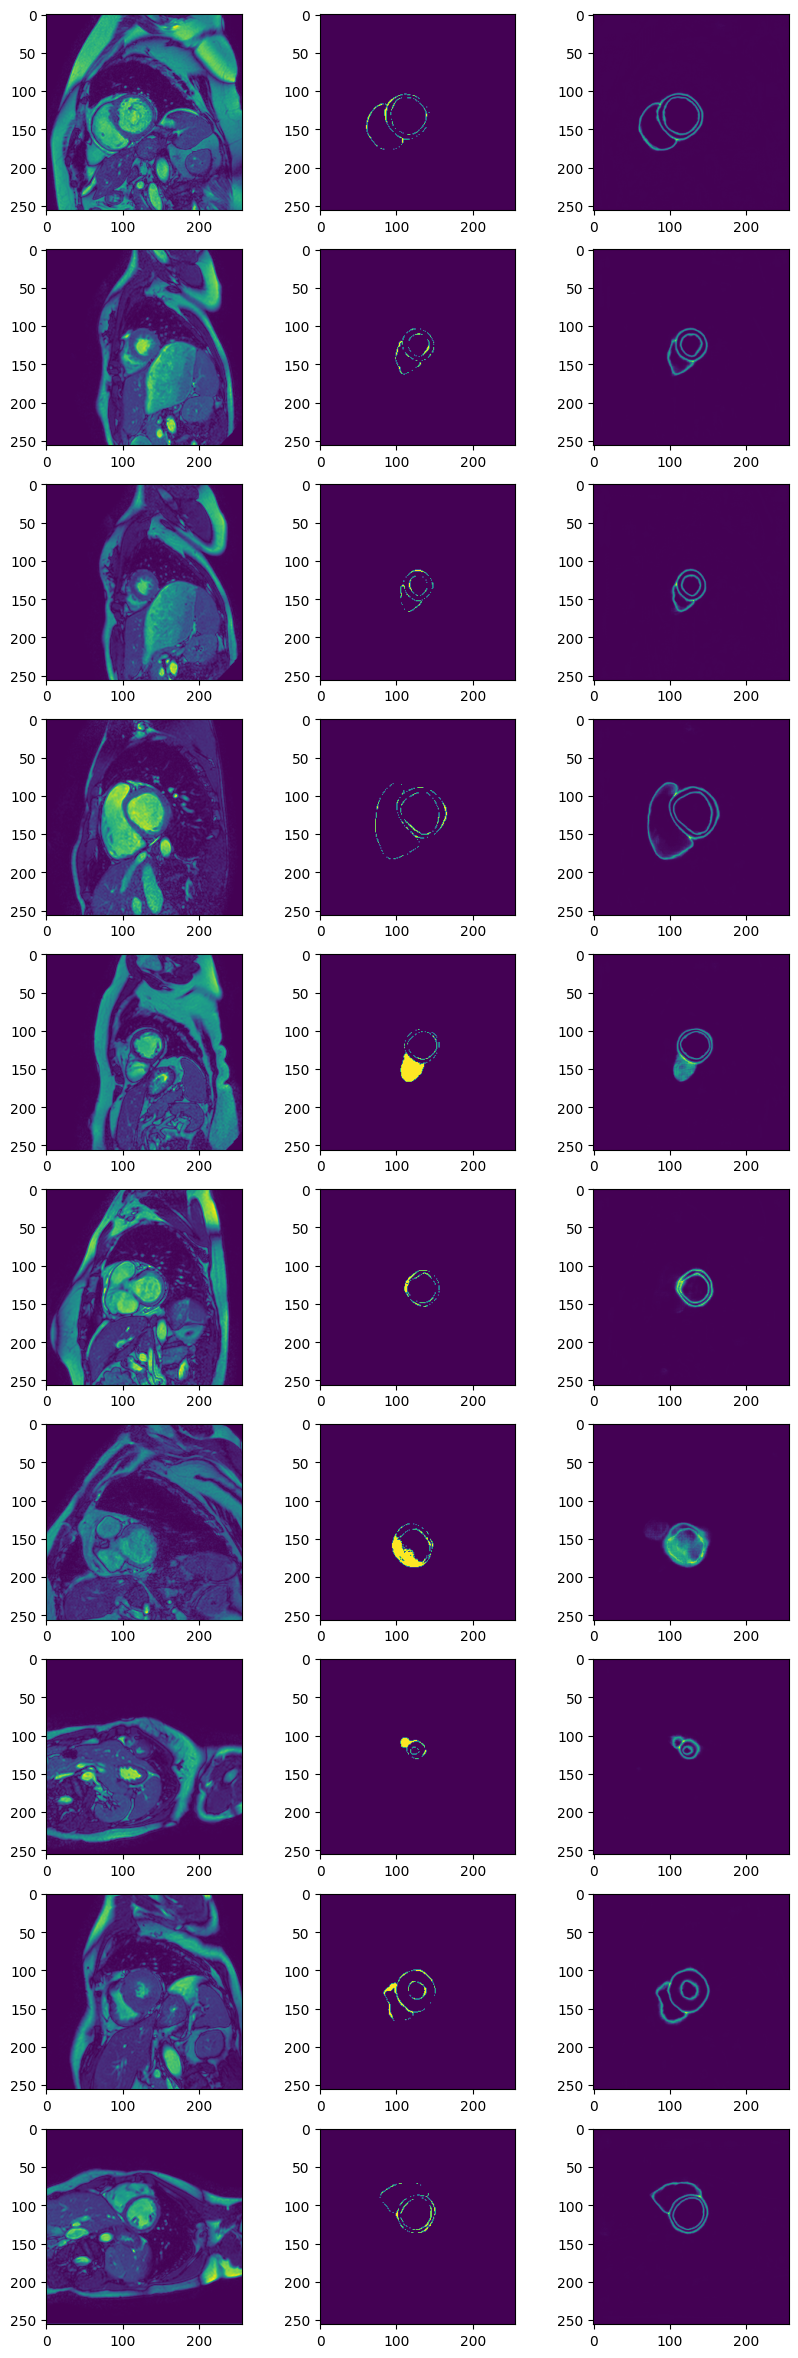

In [40]:
input_ = subset['input']
target = subset['target']
output = model(input_.to(device)).cpu()
pred = torch.argmax(output[:n], dim=1, keepdims=True)
errmap = (pred != target)
umap = umap_generator(output, batch_size=input_.shape[0])

fig, axes = plt.subplots(n, 3, figsize=(10, 3 * n))

for i in range(n):
    axes[i, 0].imshow(input_[i].squeeze())
    axes[i, 1].imshow(errmap[i].squeeze())
    axes[i, 2].imshow(umap[i].squeeze())

In [19]:
input_.shape

torch.Size([764, 1, 256, 256])

In [23]:
indices[-1:]

tensor([534])

In [30]:
values[-1:]

tensor([0.0384])

In [31]:
values[0]

tensor(0.0047)